In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown, FloatSlider, IntSlider
from ipywidgets import interactive, VBox, HBox, Output

# --- Define the parabola function ---
def f(x):
    return x**2  # simple convex function

def df(x):
    return 2*x  # derivative

# --- Optimization routine ---
def optimize(optimizer="GD", lr=0.1, epochs=20, momentum=0.9):
    x = -8 # np.random.uniform(-8, 8)  # random start
    v = 0  # momentum buffer
    history = [x]

    for i in range(epochs):
        grad = df(x)

        if optimizer == "GD":
            x = x - lr * grad

        elif optimizer == "Momentum":
            v = momentum * v - lr * grad
            x = x + v

        history.append(x)

    return np.array(history)

# --- Plotting function ---
def train_and_plot(optimizer, lr, epochs, momentum):
    xs = np.linspace(-10, 10, 400)
    ys = f(xs)

    path = optimize(optimizer, lr, epochs, momentum)
    path_y = f(path)

    plt.figure(figsize=(8,6))
    plt.plot(xs, ys, label="f(x) = x²", color="blue", alpha=0.5)
    plt.plot(path, path_y, color="red", linestyle="--", alpha=0.7, zorder=3)
    plt.scatter(path[:-1], path_y[:-1], s=60, label="Steps", marker="o", facecolors='none', edgecolors='black', zorder=4)
    plt.scatter(path[-1], path_y[-1], color="red", s=80, label="Final Step", marker="x", zorder=5)

    plt.title(f"Params: lr={lr:.2f}, epochs={epochs}, momentum={momentum:.2f}" if optimizer=="Momentum" else f"{optimizer}: lr={lr:.2f}, epochs={epochs}")
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.legend()
    plt.grid(True)
    plt.show()

# --- Widgets ---
# Define widgets with default values
optimizer_widget = Dropdown(options=["GD", "Momentum"], value="GD", description="Optimizer")

# Store defaults for reset
defaults = {
    "lr": 0.05,
    "epochs": 10,
    "momentum": 0.75
}

lr_widget = FloatSlider(value=defaults["lr"], min=0.01, max=1.0, step=0.01, description="Learning rate", readout_format=".2f")
epochs_widget = IntSlider(value=defaults["epochs"], min=5, max=100, step=5, description="Epochs")
momentum_widget = FloatSlider(value=defaults["momentum"], min=0.1, max=0.99, step=0.05, description="Momentum", readout_format=".2f")
momentum_widget.layout.visibility = 'hidden'

def on_optimizer_change(change):
    if change["name"] == "value":
        lr_widget.value = defaults["lr"]
        epochs_widget.value = defaults["epochs"]
        momentum_widget.value = defaults["momentum"]

        if change["new"] == "Momentum":
            momentum_widget.layout.visibility = 'visible'
        else:
            momentum_widget.layout.visibility = 'hidden'

optimizer_widget.observe(on_optimizer_change, names="value")

ui = VBox([optimizer_widget, lr_widget, epochs_widget, momentum_widget])
out = Output()

def wrapped_train_and_plot(optimizer, lr, epochs, momentum):
    with out:
        out.clear_output(wait=True)
        train_and_plot(optimizer, lr, epochs, momentum)

interactive_plot = interactive(
    wrapped_train_and_plot,
    optimizer=optimizer_widget,
    lr=lr_widget,
    epochs=epochs_widget,
    momentum=momentum_widget,
)

display(ui, out)


In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
covertype = fetch_ucirepo(id=31)

# --- Load dataset and sample ---
data = covertype.data.features  # UCI Covertype dataset
# Select only Elevation and Slope for a simple regression
subset = data[["Elevation", "Slope"]].sample(n=50, random_state=42)

X = subset["Elevation"].values
y = subset["Slope"].values

#%%


In [ ]:

# --- Loss function ---
def compute_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# --- Training function with different optimizers ---
def gradient_descent(x, y, lr, epochs, optimizer="GD", momentum_beta=0.9):
    w, b = np.random.randn(), np.random.randn()
    v_w, v_b = 0, 0
    losses, ws, bs = [], [], []

    for epoch in range(epochs):
        if optimizer == "GD":
            # Full batch
            y_pred = w * x + b
            dw = -2 * np.mean(x * (y - y_pred))
            db = -2 * np.mean(y - y_pred)

        elif optimizer == "SGD":
            # Single sample
            i = np.random.randint(0, len(x))
            xi, yi = x[i], y[i]
            y_pred = w * xi + b
            dw = -2 * xi * (yi - y_pred)
            db = -2 * (yi - y_pred)

        elif optimizer == "Momentum":
            y_pred = w * x + b
            dw = -2 * np.mean(x * (y - y_pred))
            db = -2 * np.mean(y - y_pred)

            v_w = momentum_beta * v_w + lr * dw
            v_b = momentum_beta * v_b + lr * db
            w -= v_w
            b -= v_b
            losses.append(compute_loss(y, w * x + b))
            ws.append(w); bs.append(b)
            continue

        # Standard update (GD or SGD)
        w -= lr * dw
        b -= lr * db

        losses.append(compute_loss(y, w * x + b))
        ws.append(w); bs.append(b)

    return ws, bs, losses

# --- Interactive plot function ---
def train_and_plot(optimizer, lr, epochs):
    ws, bs, losses = gradient_descent(X, y, lr, epochs, optimizer)

    # Final model
    y_pred = ws[-1] * X + bs[-1]

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # Left: regression fit
    axs[0].scatter(X, y, color="green", alpha=0.6, label="Data (sampled)")
    axs[0].plot(X, y_pred, color="red", linewidth=2, label="Regression line")
    axs[0].set_title(f"Fit after {epochs} epochs ({optimizer})")
    axs[0].set_xlabel("Elevation")
    axs[0].set_ylabel("Slope")
    axs[0].legend()

    # Right: loss curve
    axs[1].plot(losses, color="blue")
    axs[1].set_title("Loss over Epochs")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("MSE Loss")
    axs[1].grid(True)

    plt.show()

# --- Widgets ---
optimizer_dd = Dropdown(options=["GD", "SGD", "Momentum"], value="GD", description="Optimizer")
lr_slider = FloatSlider(value=1e-9, min=1e-9, max=1e-6, step=5e-9, description="Learning rate", readout_format=".1e")
epoch_slider = IntSlider(value=5, min=5, max=30, step=5, description="Epochs")

interact(train_and_plot, optimizer=optimizer_dd, lr=lr_slider, epochs=epoch_slider)

In [7]:
# --- Import libraries ---
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, IntSlider, Dropdown

# --- Load Covertype dataset ---
print("Loading Covertype dataset...")
covtype = fetch_covtype()
# Select 100000 random samples for further processing
sample_idx = np.random.choice(len(covtype.data), size=100000, replace=False)
X = pd.DataFrame(covtype.data[sample_idx], columns=covtype.feature_names)
y = covtype.target[sample_idx]  # integers 1–7 for cover types

print(f"Dataset shape: {X.shape}, Target shape: {y.shape}")


Loading Covertype dataset...
Dataset shape: (100000, 54), Target shape: (100000,)


In [9]:

# --- Preprocessing ---
# Identify numeric features vs categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = []  # Covertype already has binary indicators for categories

# Column transformer: standardize numeric features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)
        # No categorical encoding needed; all one-hot already encoded
    ]
)

# --- Split dataset ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


Training Random Forest classifier...

Classification report:

              precision    recall  f1-score   support

           1       0.74      0.75      0.74      7320
           2       0.76      0.83      0.79      9720
           3       0.72      0.84      0.78      1236
           4       0.89      0.41      0.56        96
           5       0.00      0.00      0.00       329
           6       0.84      0.16      0.27       594
           7       0.95      0.50      0.65       705

    accuracy                           0.75     20000
   macro avg       0.70      0.50      0.54     20000
weighted avg       0.75      0.75      0.74     20000



/Users/stefanschweng/Documents/boku_university_ddai/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/stefanschweng/Documents/boku_university_ddai/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/stefanschweng/Documents/boku_university_ddai/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

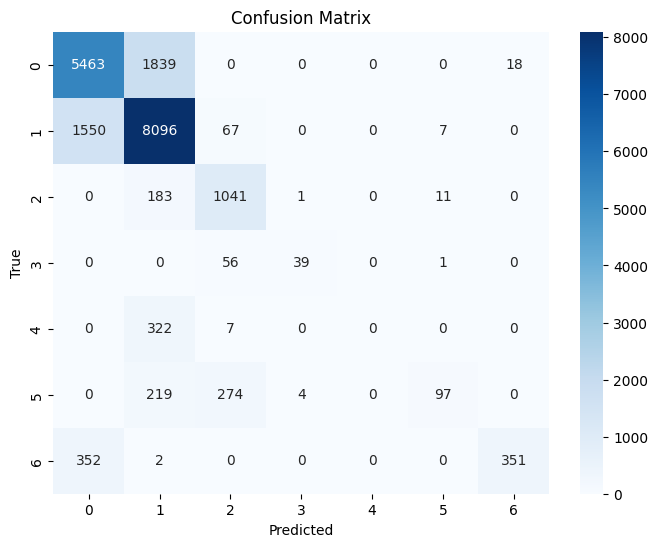

interactive(children=(IntSlider(value=100, description='Trees', max=200, min=10, step=10), IntSlider(value=10,…

<function __main__.interactive_rf(n_estimators=50, max_depth=5)>

In [10]:

# --- Build pipeline ---
clf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1))
])

# --- Fit model ---
print("Training Random Forest classifier...")
clf_pipeline.fit(X_train, y_train)

# --- Evaluate ---
y_pred = clf_pipeline.predict(X_test)
print("\nClassification report:\n")
print(classification_report(y_test, y_pred))

# --- Confusion matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# --- Interactive exploration ---
# Allow students to adjust number of trees and depth
def interactive_rf(n_estimators=50, max_depth=5):
    clf_pipeline.set_params(classifier__n_estimators=n_estimators, classifier__max_depth=max_depth)
    clf_pipeline.fit(X_train, y_train)
    score = clf_pipeline.score(X_test, y_test)
    print(f"Random Forest test accuracy with n_estimators={n_estimators}, max_depth={max_depth}: {score:.3f}")

interact(interactive_rf,
         n_estimators=IntSlider(min=10, max=200, step=10, value=100, description="Trees"),
         max_depth=IntSlider(min=2, max=20, step=1, value=10, description="Max Depth"))